## ERA5 Mean Turbulent Surface Stress

Data 2020 - downloaded resampled to daily resolution with 1-hourly (res for resampling) [Data Link](https://cds.climate.copernicus.eu/apps/user-apps/app-c3s-daily-era5-statistics?dataset=reanalysis-era5-single-levels&product_type=reanalysis&variable_e5sl=eastward_turbulent_surface_stress&pressure_level_e5sl=-&statistic=daily_mean&year_e5sl=2020&month=01&frequency=1-hourly&time_zone=UTC%2B00:00&grid_e5=0.25/0.25&area.lat:record:list:float=36&area.lat:record:list:float=45&area.lon:record:list:float=-20&area.lon:record:list:float=-5)

Units: $\frac{N}{m^2}$ 

In [80]:
## import packages
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import os
import math

In [187]:
## import data
os.chdir("/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/Surface_stress/")

TSM = xr.merge([xr.open_dataset(f) for f in glob.glob('Turbulent_mean/*_2020_*.nc')])
TSM = TSM.drop_vars(["realization"])

In [188]:
TSM

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 366, lat: 41, lon: 61)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
  * lat      (lat) float64 328B 35.0 35.25 35.5 35.75 ... 44.25 44.5 44.75 45.0
  * lon      (lon) float64 488B -20.0 -19.75 -19.5 -19.25 ... -5.5 -5.25 -5.0
Data variables:
    metss    (time, lat, lon) float32 4MB -0.0188 -0.02123 ... 0.0962 0.0971
    mntss    (time, lat, lon) float32 4MB 0.06717 0.06465 ... -0.1021 -0.09993
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-04-12T14:59 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

In [5]:
len(TSM.time.values)

366

In [9]:
# starts week on the sunday
TSM_weekly_mean = TSM.resample(time = '1W', label = 'left').mean() 
TSM_weekly_std = TSM.resample(time = '1W', label = 'left').std() 

In [10]:
TSM_weekly_std

<xarray.Dataset> Size: 1MB
Dimensions:      (lat: 41, lon: 61, time: 53)
Coordinates:
  * lat          (lat) float64 328B 35.0 35.25 35.5 35.75 ... 44.5 44.75 45.0
  * lon          (lon) float64 488B -20.0 -19.75 -19.5 ... -5.5 -5.25 -5.0
    realization  int64 8B 0
  * time         (time) datetime64[ns] 424B 2019-12-29 2020-01-05 ... 2020-12-27
Data variables:
    metss        (time, lat, lon) float32 530kB 0.01492 0.01435 ... 0.2054
    mntss        (time, lat, lon) float32 530kB 0.021 0.02081 ... 0.08706
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-04-12T14:59 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

In [121]:
## calculate depth integrated Ekman transport
# method based on Oxford Lecture 7 (maybe find better reference
# calculate the Coriolis parameter f
omega = 7.2921159e-5                          # angular velocity -> rad/s
lat_rad = TSM.lat * (np.pi / 180)             # latitude in radians -> rad
f = 2 * omega * np.sin(lat_rad.values)        # Coriolis parameter -> rad/s^2

# create a cube that fits the shape of our xarray and fill it with the calculated f at the appropriate latitude
TSM_weekly_shape = TSM_weekly_mean.mntss.shape
f_cube = np.ones(TSM_weekly_shape)
for i in np.arange(0,41):
    f_cube[:,i,:] = f[i]

# density of seawater
phi = 1025                                    # density of seawater -> kg/m^3

In [201]:
# to avoid any weird variable attributes appearing where they don't belong
xr.set_options(keep_attrs=False)

TSM_weekly_mean['hypot'] = np.hypot(TSM_weekly_mean.metss, TSM_weekly_mean.mntss)
TSM_weekly_mean.Ek_trans_u.attrs.update({"name" : "combined wind stress", "units" : "N/m^2"})

TSM_weekly_mean['Ek_trans_U'] = TSM_weekly_mean.mntss / (phi * f_cube)    # m^2/s -> eastward transport (u) is calculated from wind in northward direction (v)
TSM_weekly_mean.Ek_trans_U.attrs.update({"name" : "eastward Ekman transport integrated across Ekman layer (U_Ek)", "units" : "m^2/s", "ref" : "Lecture 7, Oxford"})

TSM_weekly_mean['Ek_trans_V'] = TSM_weekly_mean.metss / (phi * f_cube)    # m^2/s -> northward transport (v) is calculated from wind in eastward direction (u)
TSM_weekly_mean.Ek_trans_V.attrs.update({"name" : "northward Ekman transport integrated across Ekman layer (V_Ek)", "units" : "m^2/s", "ref" : "Lecture 7, Oxford"})

In [202]:
## calculate upwelling index (based on Gomez-Gesteira et al. 2006 -> maybe find better/original ref)

# I need the angle of the coast ... as this is a large scale process I will just go with the approximate angle 
# prehaps refine later

coast_angle = 0 # assuming 0 degree angle (= 0 rads) as Portugues coast is pretty well aligned with stratigh south-north direction
angle = 90 # angle of the unitary vector perpendicular to coast pointing landward -› positive UI values mean upwelling favourable conditions
angle_rad = 90 * (np.pi/180)

theta = np.pi/2 + angle_rad

TSM_weekly_mean['UI'] = -np.sin(theta)*TSM_weekly_mean.Ek_trans_U + np.cos(theta)*TSM_weekly_mean.Ek_trans_V
TSM_weekly_mean.UI.attrs.update({"name" : "upwelling index", "info" : "positive values upwelling favourable \nassuming Portuguese coast at 0°", "ref" : "Gomez-Gesteira et al. 2006"})


In [203]:
TSM_weekly_mean

<xarray.Dataset> Size: 7MB
Dimensions:      (lat: 41, lon: 61, time: 53)
Coordinates:
  * lat          (lat) float64 328B 35.0 35.25 35.5 35.75 ... 44.5 44.75 45.0
  * lon          (lon) float64 488B -20.0 -19.75 -19.5 ... -5.5 -5.25 -5.0
    realization  int64 8B 0
  * time         (time) datetime64[ns] 424B 2019-12-29 2020-01-05 ... 2020-12-27
Data variables:
    metss        (time, lat, lon) float32 530kB -0.01454 -0.0139 ... 0.3236
    mntss        (time, lat, lon) float32 530kB 0.02951 0.02765 ... -0.1822
    hypot        (time, lat, lon) float32 530kB 0.0329 0.03094 ... 0.3722 0.3713
    Ek_trans_u   (time, lat, lon) float64 1MB 0.3442 0.3224 ... -1.747 -1.724
    Ek_trans_v   (time, lat, lon) float64 1MB -0.1696 -0.1621 ... 3.057 3.061
    Ek_trans_U   (time, lat, lon) float64 1MB 0.3442 0.3224 ... -1.747 -1.724
    Ek_trans_V   (time, lat, lon) float64 1MB -0.1696 -0.1621 ... 3.057 3.061
    UI           (time, lat, lon) float64 1MB 0.1696 0.1621 ... -3.057 -3.061
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-04-12T14:59 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

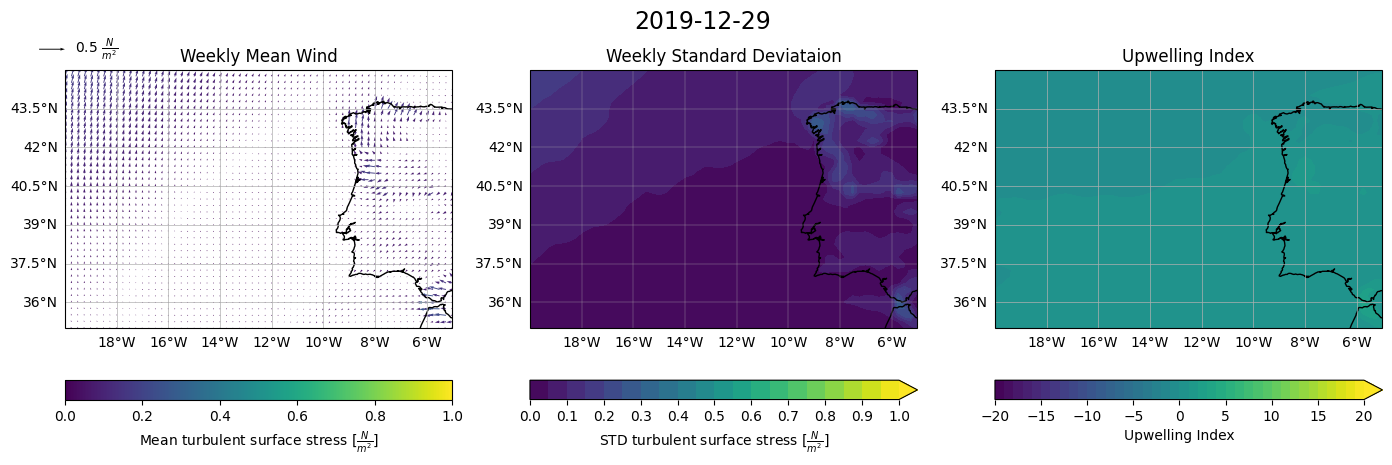

In [219]:
for i in np.arange(0, len(TSM_weekly_mean.time.values), 1):
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (17, 4.5), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # set up cartopy
    ax1.set_extent([-20, -5, 45, 35])
    ax1.coastlines()
    gls = ax1.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
    # plot data
    col = np.hypot(TSM_weekly_mean.metss.isel(time = i), TSM_weekly_mean.mntss.isel(time = i))
    im1 = ax1.quiver(TSM_weekly_mean.lon, TSM_weekly_mean.lat, TSM_weekly_mean.metss.isel(time = i), TSM_weekly_mean.mntss.isel(time = i), 
                     col, clim = [0,1], 
                     angles='xy', scale_units='xy', scale = 0.5)
    ax1.set_title('Weekly Mean Wind')
    plt.colorbar(im1, orientation = 'horizontal', label = r'Mean turbulent surface stress [$\frac{N}{m^2}$]', fraction = 0.06)
    qk1 = ax1.quiverkey(im1, 0, 1.08, 0.5, r'0.5 $\frac{N}{m^2}$', labelpos='E')
    
    # set up cartopy
    ax2.set_extent([-20, -5, 45, 35])
    ax2.coastlines()
    gls = ax2.gridlines(draw_labels=True, linewidth = 0.25)
    gls.top_labels = False 
    gls.right_labels = False
    # plot std as function the length of the hypothenuse -> combine the vectors
    dat = np.hypot(TSM_weekly_std.metss.isel(time = i), TSM_weekly_std.mntss.isel(time = i))
    im2 = ax2.contourf(TSM_weekly_std.lon, TSM_weekly_std.lat, dat, transform = ccrs.PlateCarree(), levels = np.arange(0, 1.05, 0.05), extend = 'max')
    ax2.set_title('Weekly Standard Deviataion')
    #ax2.quiver(TSM_weekly_std.lon, TSM_weekly_std.lat, TSM_weekly_std.metss.isel(time = i), TSM_weekly_std.mntss.isel(time = i)) # if I wanted to preserver information on direction I'd have to plot this
    plt.colorbar(im2, orientation = 'horizontal', label = r'STD turbulent surface stress [$\frac{N}{m^2}$]', fraction = 0.06, ticks = np.arange(0, 1.1, 0.1))

    # set up cartopy
    ax3.set_extent([-20, -5, 45, 35])
    ax3.coastlines()
    gls = ax3.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
    # plot data
    im3 = ax3.contourf(TSM_weekly_mean.lon, TSM_weekly_mean.lat, TSM_weekly_mean.UI.isel(time = i), transform = ccrs.PlateCarree(), levels = np.arange(-20, 21, 1), extend = 'max')
    ax3.set_title('Upwelling Index')
    plt.colorbar(im3, orientation = 'horizontal', label = r'Upwelling Index', fraction = 0.06, ticks = np.arange(-20, 25, 5))
    
    fig.suptitle(f'{str(TSM_weekly_mean.time[i].values)[0:10]}', fontsize = 17);
    #fig.tight_layout()


In [ ]:
# write as function
def Upwelling_index(weeekly_mean_data):